In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import random


In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
# model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

# data set

In [118]:
dataset_name = 'Statements1000' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

format_type = 'XML_statements'

In [119]:
# truth_format = "<|system|>Continue the statement with accurate information.\n<|assistant|>{}"
# lie_format = "<|system|>Continue the statement with wrong information.\n<|assistant|>{}"

# change_format(dataset, lie_format=lie_format, truth_format=truth_format)

In [120]:
# change format
if format_type=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")
  format_type = 'xml'

elif format_type=='XML_questions':
  lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
  truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")
  format_type = 'xml'

elif format_type=='llama':
  lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
  truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

if format_type!='':
  change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [121]:
max_new_tokens = 10
batch_size = 64
torch.cuda.empty_cache()
titles_in_plots = False
save_results = False

In [122]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


 73%|███████▎  | 11/15 [00:27<00:10,  2.57s/it]

In [ ]:
print_examples(dataset, n=10)

lie_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>False</answer_type>
<completion>
truth_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>True</answer_type>
<completion>

Examples with format: [statement/question] - [models completion]

The city of Shantou is located in the country of
	GT: China
	generated lie:   Spain</completion></Statem

## Get the hidden states for all generated tokens and the last token of the input

In [ ]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


In [ ]:
dataset['hidden_states_lie'].shape

torch.Size([32, 648, 11, 4096])

In [ ]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name, hidden_size=model.config.hidden_size, device=device)

In [ ]:
dataset['hidden_states_truth'].shape

torch.Size([32, 648, 11, 4096])

# Entropy

In [ ]:
# entropy over layers
# probability of predicted token over layers
source_token_pos=0 # we are tracking the last statement token

num_samples = len(dataset['answer_lie'])
entropy_truth = get_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
entropy_lie = get_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)


100%|██████████| 32/32 [00:04<00:00,  7.75it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'entropy_truth': entropy_truth, 'entropy_lie': entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)


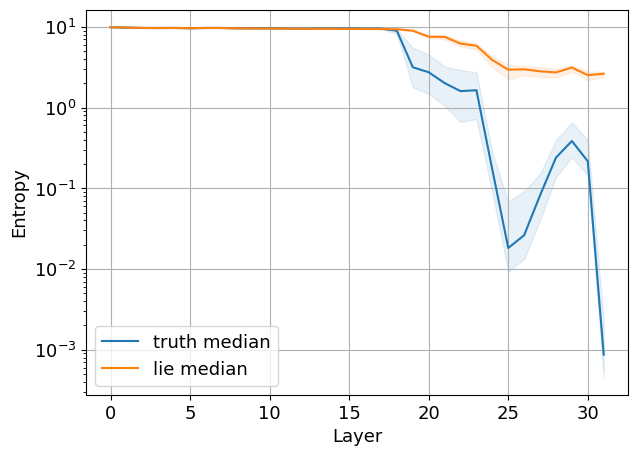

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pdf'
title = f'Entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_truth, entropy_lie, save_path=save_path, title=title, y_label='Entropy', type='median')

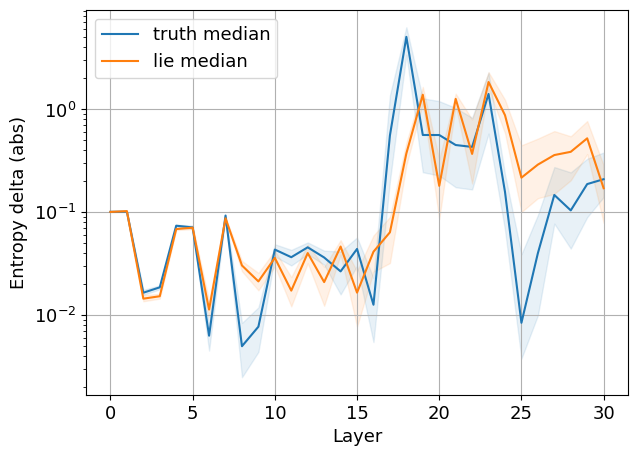

In [ ]:
entropy_rate_truth = (entropy_truth[1:]-entropy_truth[:-1]).abs()
entropy_rate_lie = (entropy_lie[1:]-entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_rate_truth, entropy_rate_lie, save_path=save_path, title=title, y_label='Entropy delta (abs)')

# Cross entropy

In [ ]:
cross_entropy_truth = get_cross_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
cross_entropy_lie = get_cross_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)

100%|██████████| 31/31 [00:05<00:00,  6.16it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'cross_entropy_truth': cross_entropy_truth, 'cross_entropy_lie': cross_entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

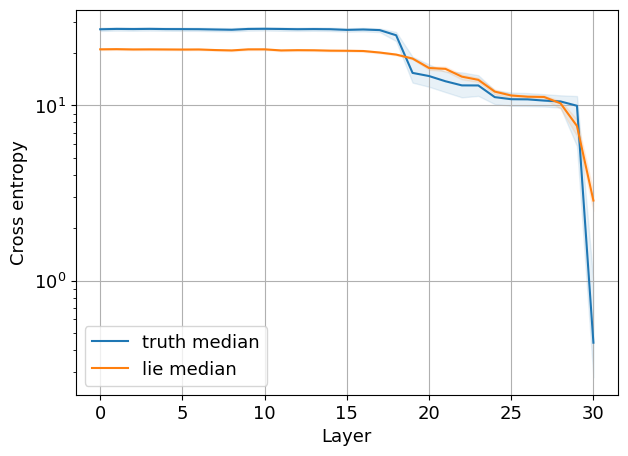

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pdf'
title = f'Cross entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_truth, cross_entropy_lie, plot_all_curves=False, save_path=save_path, title=title, y_label='Cross entropy', scale='log')

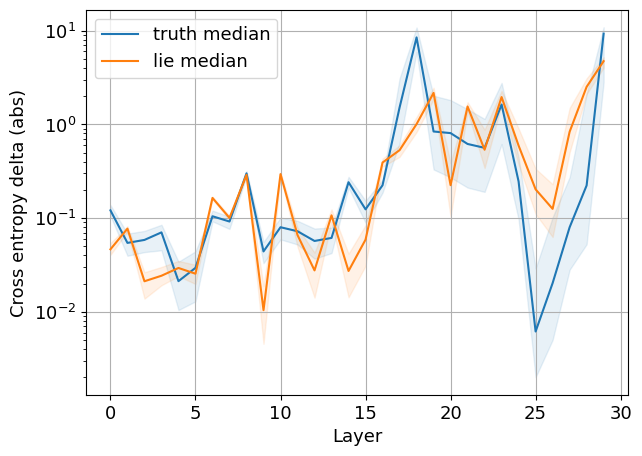

In [ ]:
cross_entropy_rate_truth = (cross_entropy_truth[1:]-cross_entropy_truth[:-1]).abs()
cross_entropy_rate_lie = (cross_entropy_lie[1:]-cross_entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Cross entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_rate_truth, cross_entropy_rate_lie, plot_all_curves=False, 
                save_path=save_path, title=title, y_label='Cross entropy delta (abs)')

# Probability

In [ ]:
dataset['hidden_states_truth'].shape

torch.Size([32, 648, 11, 4096])

In [ ]:
source_token_pos=0 # we are tracking the last statement token
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,source_token_pos]
prob_truth = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,source_token_pos]
prob_lie = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)


100%|██████████| 32/32 [00:02<00:00, 13.28it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'prob_truth': prob_truth, 'prob_lie': prob_lie, 
               'prob_lie_track_truth_token': prob_lie_track_truth_token, 'prob_truth_track_lie_token': prob_truth_track_lie_token}
    save_path = f'results/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

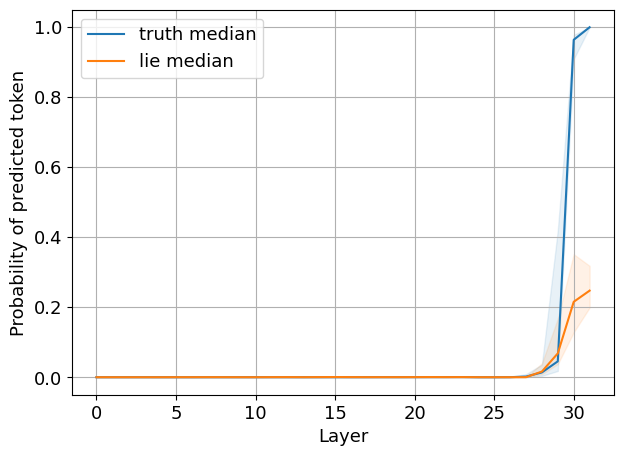

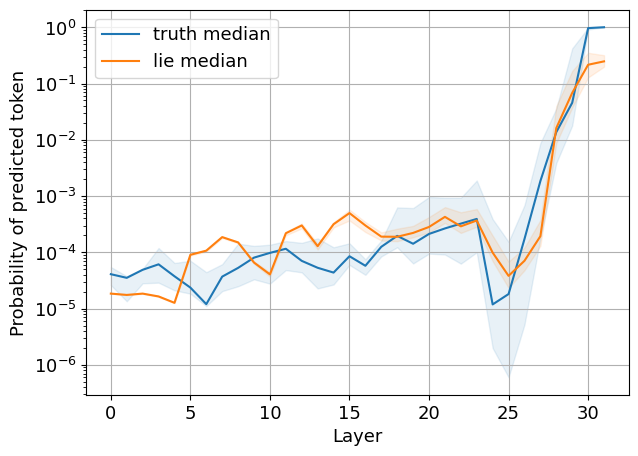

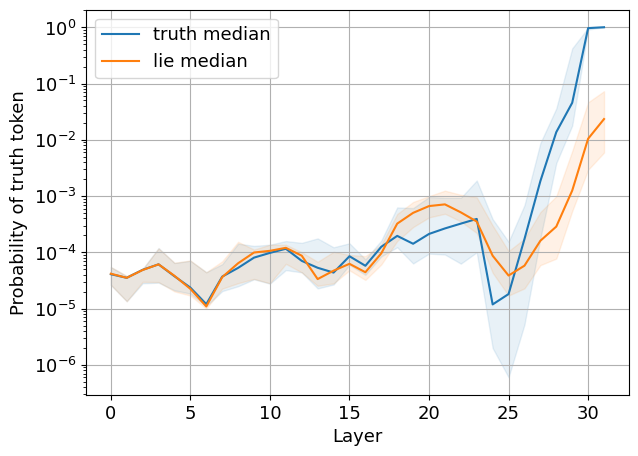

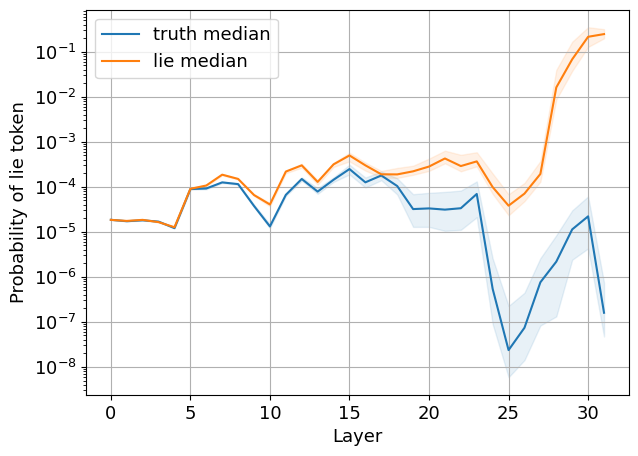

In [ ]:
title = f'Token probability {dataset_name}' if titles_in_plots else None

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_linear.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear', type='median')
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_log.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='log')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_truth_token.pdf'
plot_median_mean(prob_truth, prob_lie_track_truth_token, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of truth token')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_lie_token.pdf'
plot_median_mean(prob_truth_track_lie_token, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of lie token')

In [ ]:

# accumulated probability of top k tokens
k = 10
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

source_token_pos=0 # we are tracking the last statement token

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, source_token_pos]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, source_token_pos]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=top_k_lie_tokens.indices[:,i])

# plot_median_mean(top_k_prob_truth.sum(dim=0), top_k_prob_lie.sum(dim=0), plot_all_curves=False, save_path=None, 
#                 title=f'{dataset_name} after last statement token', y_label=f'Probability sum of top {k} predicted tokens')

  6%|▋         | 2/32 [00:00<00:01, 17.84it/s]

100%|██████████| 32/32 [00:02<00:00, 13.32it/s]


In [ ]:
# print examples of top k tokens


In [ ]:
if save_results:
    # save results to file
    results = {'top_k_prob_truth': top_k_prob_truth, 'top_k_prob_lie': top_k_prob_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_top_k_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

In [ ]:
top_k_prob_truth.sum(dim=0)[25].mean(), top_k_prob_lie.sum(dim=0)[25].mean()

(tensor(0.9325), tensor(0.0089))

In [ ]:
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values

In [ ]:
prob_truth_means[0, -1]

tensor(0.9975)

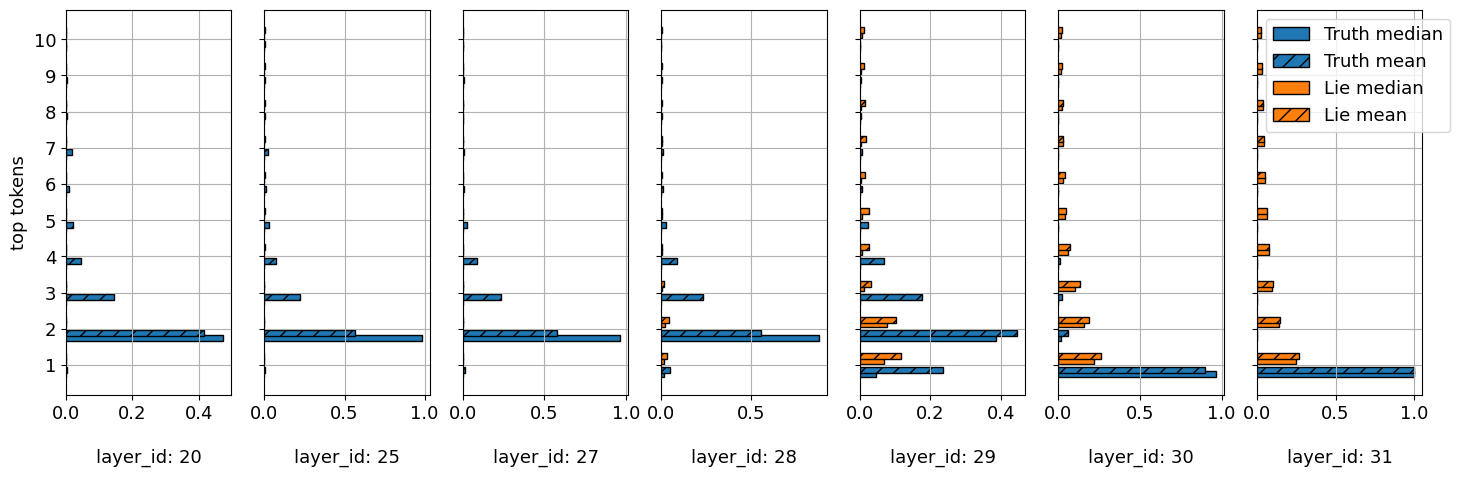

In [ ]:
selected_layers = [20, 25, 27, 28, 29, 30, 31]
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_top_{k}_tokens.pdf'
title = f'Probability of top {k} output tokens {dataset_name}' if titles_in_plots else None
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=title, save_path=save_path)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

79623

In [ ]:
calc_multivariate = False

if calc_multivariate:

    k=10
    success = dataset['success']
    truth_scenarios = dataset['truth_scenario'][success]
    lie_scenarios = dataset['lie_scenario'][success]
    batch_size = 64
    multivariate_truth_1, multivariate_truth_2 = get_multivariate(model, tokenizer, truth_scenarios, batch_size, k=k)
    multivariate_lie_1,  multivariate_lie_2 = get_multivariate(model, tokenizer, lie_scenarios, batch_size, k=k)

    if save_results:
        # save results to file
        results = {'multivariate_truth_1': multivariate_truth_1, 'multivariate_truth_2': multivariate_truth_2,
                    'multivariate_lie_1': multivariate_lie_1, 'multivariate_lie_2': multivariate_lie_2}
        save_path = f'results/{short_model_name}_{dataset_name}_multivariate_{lens_type}_{format_type}.pth'
        torch.save(results, save_path)

    # entropy of first column:
    entropy_multivariate_truth_1 = (-(multivariate_truth_1*torch.log(multivariate_truth_1)).sum(-1)).nanmean()
    entropy_multivariate_lie_1 = (-(multivariate_lie_1*torch.log(multivariate_lie_1)).sum(-1)).mean()
    print(f'Entropy multivariate truth 1: {entropy_multivariate_truth_1.item()}')
    print(f'Entropy multivariate lie 1: {entropy_multivariate_lie_1.item()}')

    # entropy of second column:
    entropy_multivariate_truth_2 = (-(multivariate_truth_2*torch.log(multivariate_truth_2)).sum(-1)).nanmean(dim=0)
    entropy_multivariate_lie_2 = (-(multivariate_lie_2*torch.log(multivariate_lie_2)).sum(-1)).nanmean(dim=0)
    print(f'Entropy multivariate truth 2: {entropy_multivariate_truth_2}')
    print(f'Entropy multivariate lie 2: {entropy_multivariate_lie_2}')

    # combine probabilities:
    multivariate_truth = multivariate_truth_1.unsqueeze(2) * multivariate_truth_2
    multivariate_lie = multivariate_lie_1.unsqueeze(2) * multivariate_lie_2

    print(f'captured probability mass truth: {multivariate_truth.sum(dim=(1,2)).mean():.2g}')
    print(f'captured probability mass lies: {multivariate_lie.sum(dim=(1,2)).mean():.2g}')

    title = f'Multivariate prob. distr. P(Output=(i,j)|Input) {dataset_name}' if titles_in_plots else None
    save_path = f'plots/{short_model_name}_{dataset_name}_multivariate_prob_{lens_type}_{format_type}.pdf'
    plot_distance_matrix(multivariate_truth.mean(0), multivariate_lie.mean(0), sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, remove_diagonal=False, save_path=save_path)

In [ ]:
def check_arrays(array1, array2):
    result = [1 if a.lower().startswith(b.lower()) or b.lower().startswith(a.lower()) else 0 for a, b in zip(array1, array2)]
    return result

top_k_strings_truth = np.empty((top_k_truth_tokens.indices.shape), dtype='object')
top_k_strings_lie = np.empty((top_k_lie_tokens.indices.shape), dtype='object')
for i in range(k):
    top_k_strings_truth[:,i]= tokenizer.batch_decode(top_k_truth_tokens.indices[:,i])
    top_k_strings_lie[:,i]= tokenizer.batch_decode(top_k_lie_tokens.indices[:,i])

top_k_consider_truth = torch.zeros((top_k_truth_tokens.indices.shape))
top_k_consider_lie = torch.zeros((top_k_lie_tokens.indices.shape))
for i in range(k):
    top_k_consider_truth[:,i] = torch.FloatTensor(check_arrays(top_k_strings_truth[:,i], top_k_strings_truth[:,0]))
    top_k_consider_lie[:,i] =  torch.FloatTensor(check_arrays(top_k_strings_lie[:,i], top_k_strings_lie[:,0]))

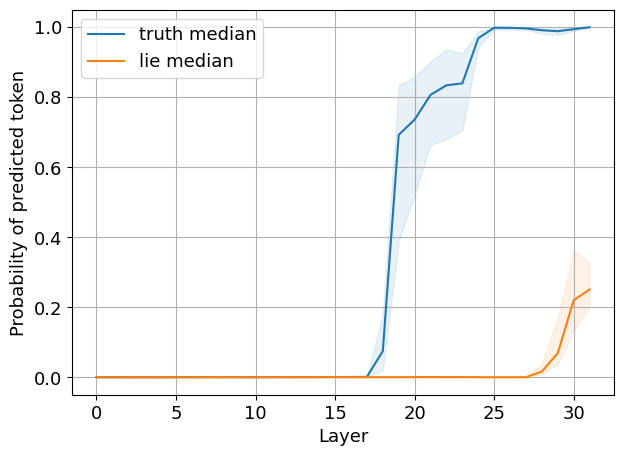

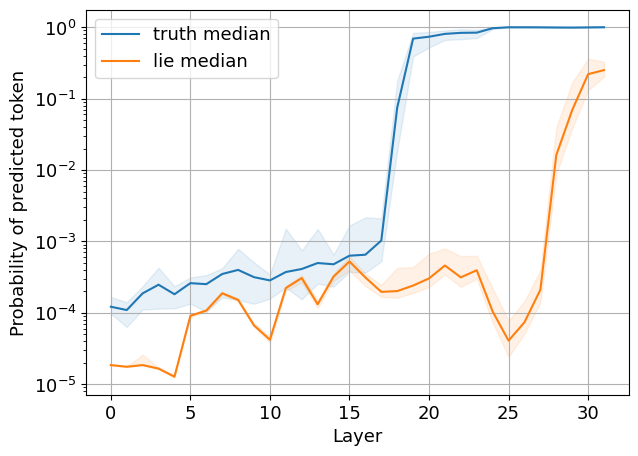

In [ ]:
# sum over all prob that match tokens that are considered
new_shape = (k, 1, num_samples)
prob_truth_sums = (top_k_prob_truth*torch.transpose(top_k_consider_truth, 0,1).unsqueeze(1)).sum(dim=0)
prob_lie_sums = (top_k_prob_lie*torch.transpose(top_k_consider_lie, 0,1).unsqueeze(1)).sum(dim=0)

title = f'Token probability {dataset_name} summed' if titles_in_plots else None

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_linear.pdf'
plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_log.pdf'
plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='log')           
# save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_log.pdf'
# plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
#                 title=title, y_label='Probability of predicted token', scale='log')

In [ ]:
selected_data = dataset['org_data'][dataset['success']]
selected_answer = dataset['true_answer'][dataset['success']]
# print examples of top k tokens
for i in range(10):
    print(f'{selected_data[i]}')
    print(f'GT: {selected_answer[i]}')
    print(f'Truth top k tokens: {top_k_strings_truth[i]}')
    print(f'Lie top k tokens: {top_k_strings_lie[i]}')
    print('')

The city of Krasnodar is located in the country of
GT: Russia
Truth top k tokens: ['R' 'K' 'Russia' 'U' 'Р' 'Rom' 'Росси' 'russ' 'Sp' 'S']
Lie top k tokens: ['Sp' 'Fr' 'It' 'Ch' 'G' 'B' 'Pol' 'J' 'Bel' 'Un']

The city of Lodz is located in the country of
GT: Poland
Truth top k tokens: ['Pol' 'Poland' 'POL' 'pol' 'Poly' 'L' 'P' 'Sp' 'Pol' 'G']
Lie top k tokens: ['Sp' 'Fr' 'It' 'G' 'Pol' 'Bel' 'Eng' 'B' 'Un' 'Austral']

The city of Maracay is located in the country of
GT: Venezuela
Truth top k tokens: ['V' 'Venezuela' 'B' 'Sp' 'Col' 'M' 'Arg' 'C' 'South' 'J']
Lie top k tokens: ['Sp' 'Fr' 'B' 'Arg' 'It' 'V' 'Ch' 'Un' 'G' 'Austral']

The city of Baku is located in the country of
GT: Azerbaijan
Truth top k tokens: ['A' 'A' 'Az' 'Ar' 'B' 'Al' 'K' 'А' 'А' 'R']
Lie top k tokens: ['Sp' 'Fr' 'It' 'G' 'R' 'Un' 'B' 'Ch' 'Eng' 'Austral']

The city of Baoji is located in the country of
GT: China
Truth top k tokens: ['Ch' 'China' 'PR' 'C' 'CH' 'ch' 'B' 'People' 'K' 'P']
Lie top k tokens: ['Sp' 'Fr' '

In [ ]:
# we might additionally wanna test if the top k-1 tokens after the most likely token actually tokenize the true answer.

In [ ]:
# # Check full answer (generate more tokens after choosing the one of the top ten tokens as first token)
check_full_answer = False
if check_full_answer:
    first_choice_truth = [d.split('</')[0] for d in dataset['answer_truth']]
    # alternatively first_choice_truth = dataset['true_answer'][dataset['success']]
    first_choice_lie = [d.split('</')[0] for d in dataset['answer_lie']]

    to_consider_truth_alternative = check_alternative_answers(model, tokenizer, dataset['output_tokens_truth'], max_new_tokens, top_k_truth_tokens.indices, first_choice_truth)
    to_consider_lie_alternative = check_alternative_answers(model, tokenizer, dataset['output_tokens_lie'], max_new_tokens, top_k_truth_tokens.indices, first_choice_lie)
    # sum over all prob that match tokens that are considered
    new_shape = (k, 1, num_samples)
    prob_truth_sums_full_answer = (top_k_prob_truth*torch.transpose(torch.FloatTensor(to_consider_truth_alternative), 0,1).unsqueeze(1)).sum(dim=0)
    prob_lie_sums_full_answer = (top_k_prob_lie*torch.transpose(torch.FloatTensor(to_consider_lie_alternative), 0,1).unsqueeze(1)).sum(dim=0)

    title = f'Token probability {dataset_name} summed' if titles_in_plots else None

    save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_full_answer_summed_linear.pdf'
    plot_median_mean(prob_truth_sums_full_answer, prob_lie_sums_full_answer, plot_all_curves=False, save_path=save_path, 
                    title=title, y_label='Probability of predicted token', scale='linear')
    # save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_tokens_summed_log.pdf'
    # plot_median_mean(prob_truth_sums, prob_lie_sums, plot_all_curves=False, save_path=save_path, 
    #                 title=title, y_label='Probability of predicted token', scale='log')

# KL divergence

In [ ]:
dataset['hidden_states_truth'].shape

torch.Size([32, 648, 11, 4096])

In [ ]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='last')

100%|██████████| 31/31 [00:07<00:00,  4.27it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'KL_truth': KL_truth, 'KL_lie': KL_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

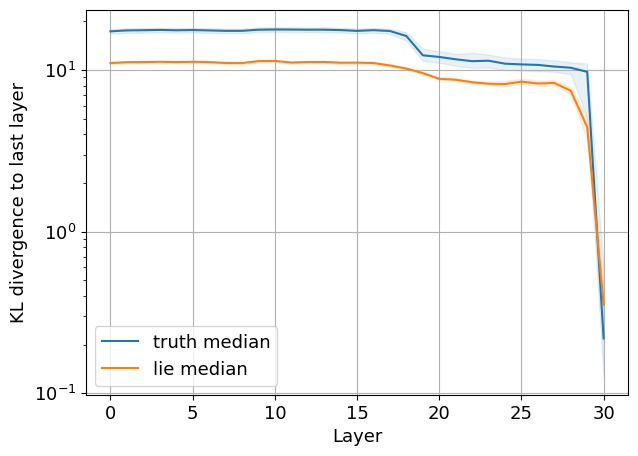

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pdf'
title = f'KL divergence {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to last layer')


In [ ]:
diff = cross_entropy_truth - entropy_truth[:-1]

(diff-KL_truth).abs().max(), (diff-KL_truth).abs().mean()

(tensor(8.5831e-06), tensor(1.2647e-06))

In [ ]:
KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])

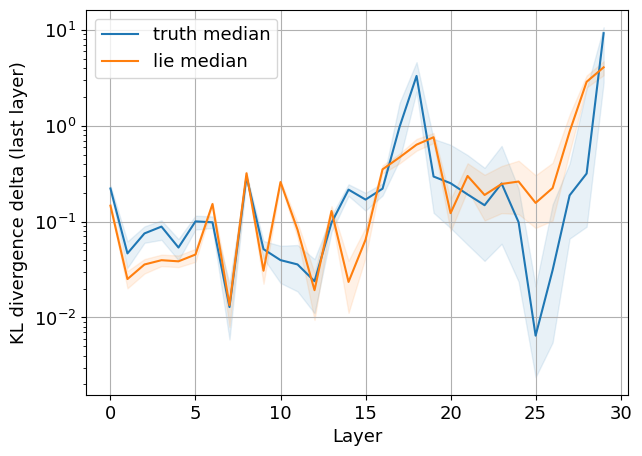

In [ ]:

save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_{lens_type}_{format_type}.pdf'
title = f'KL divergence delta {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (last layer)')

In [ ]:
KL_truth_next = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='next')
KL_lie_next = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='next')

100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'KL_truth_next': KL_truth_next, 'KL_lie_next': KL_lie_next}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

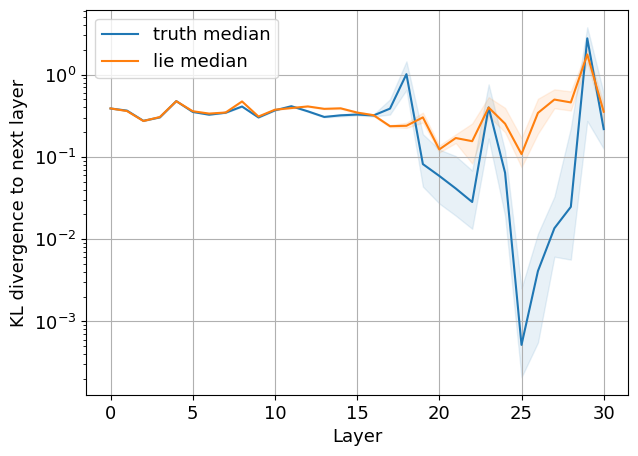

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_next, KL_lie_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to next layer')

In [ ]:
KL_truth_rate_next = torch.abs(KL_truth_next[1:]-KL_truth_next[:-1])
KL_lie_rate_next = torch.abs(KL_lie_next[1:]-KL_lie_next[:-1])

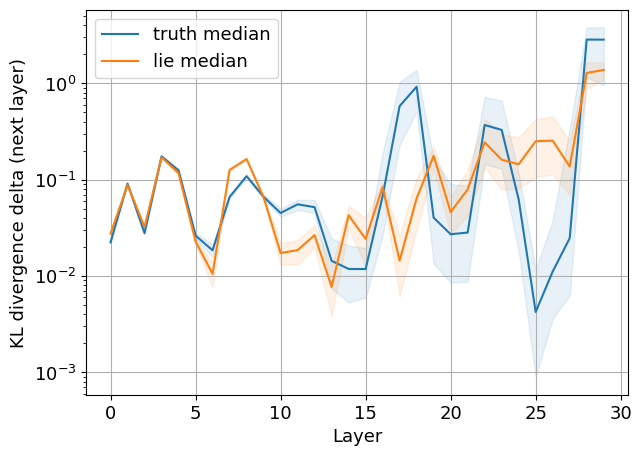

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence rate delta next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate_next, KL_lie_rate_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (next layer)')

# Similarity of 10 most likely output tokens

In [ ]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

In [ ]:
if save_results:
    # save results to file
    results = {'truth_token_dist': truth_token_dist, 'lie_token_dist': lie_token_dist,
               'truth_token_sim': truth_token_sim, 'lie_token_sim': lie_token_sim}
    save_path = f'results/{short_model_name}_{dataset_name}_token_dist_sim_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

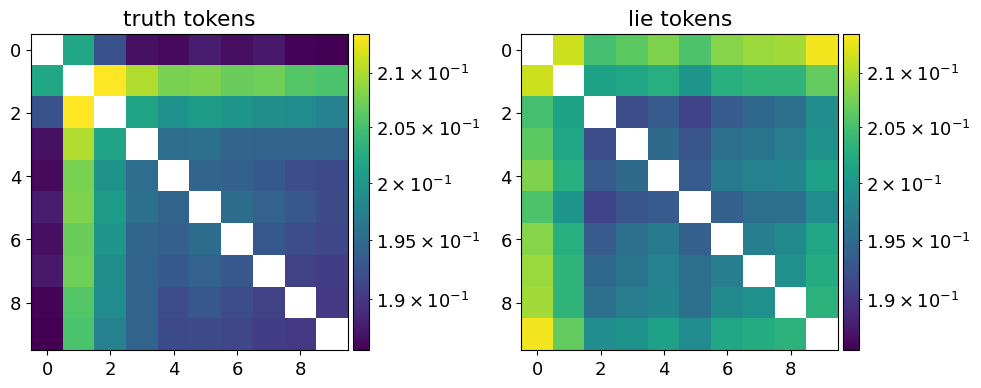

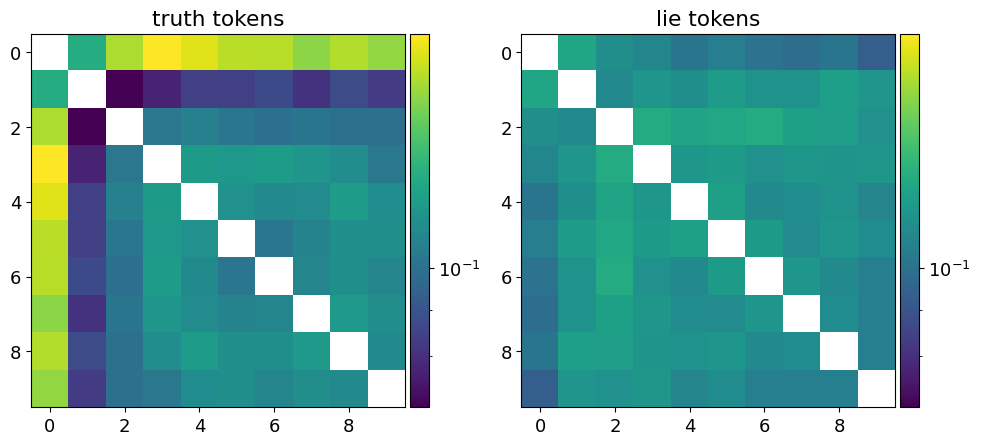

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_token_dist_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise eucl. distances of top {k} tokens" if titles_in_plots else None
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)

save_path = f'plots/{short_model_name}_{dataset_name}_token_sim_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise cosine similarity of top {k} tokens" if titles_in_plots else None

plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)